total Dataset of val2017 is :  1
/home/oishii/Documents/pytorch-CycleGAN-and-pix2pix/checkpoints/1e3_bs8_256_X_pix2pix_radhnv3xgaussian 0.9940840484190551 34.67562071284189 12.663884480794271 [781]
total Dataset of val2017 is :  1
/home/oishii/Documents/pytorch-CycleGAN-and-pix2pix/checkpoints/1e3_bs8_256_2017_pix2pix 0.9443323184773403 21.595289469563014 19.057022094726562 [781]


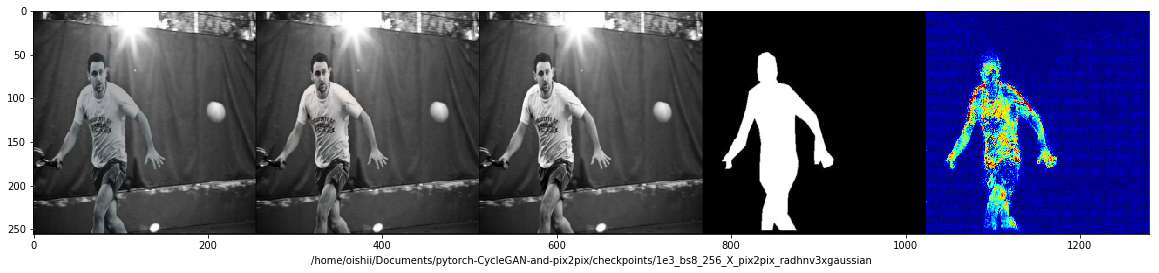

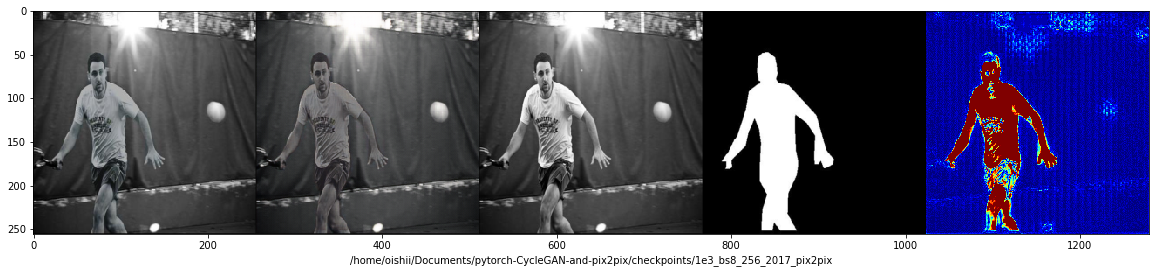

In [68]:
from __future__ import print_function, absolute_import

import os 
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import sys, math
sys.path.append('..')

import scripts.utils
from scripts.utils.logger import Logger, savefig
from scripts.utils.evaluation import accuracy, AverageMeter, final_preds
from scripts.utils.misc import save_checkpoint, save_pred, adjust_learning_rate
from scripts.utils.osutils import mkdir_p, isfile, isdir, join
from scripts.utils.imutils import batch_with_heatmap,normalize_batch,im_to_numpy
from scripts.utils.transforms import fliplr, flip_back
import scripts.models as models
import scripts.datasets as datasets
import random
from matplotlib import cm
 
def get_jet():
    colormap_int = np.zeros((256, 3), np.uint8)
 
    for i in range(0, 256, 1):
        colormap_int[i, 0] = np.int_(np.round(cm.jet(i)[0] * 255.0))
        colormap_int[i, 1] = np.int_(np.round(cm.jet(i)[1] * 255.0))
        colormap_int[i, 2] = np.int_(np.round(cm.jet(i)[2] * 255.0))

    return colormap_int

jet_map = get_jet()

def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

def gray2color(gray_array, color_map):
    
    rows, cols = gray_array.shape
    color_array = np.zeros((rows, cols, 3), np.uint8)
 
    for i in range(0, rows):
        for j in range(0, cols):
#             log(256,2) = 8 , log(1,2) = 0 * 8
            color_array[i, j] = color_map[clamp(int(abs(gray_array[i, j])*10),0,255)]
    
    return color_array


from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

class objectview(object):
    def __init__(self, *args, **kwargs):
        d = dict(*args, **kwargs)
        self.__dict__ = d

methods = ['/home/oishii/Documents/pytorch-CycleGAN-and-pix2pix/checkpoints/1e3_bs8_256_X_pix2pix_radhnv3xgaussian',
          '/home/oishii/Documents/pytorch-CycleGAN-and-pix2pix/checkpoints/1e3_bs8_256_2017_pix2pix']

dataset_name= 'val2017'
dataroot = '/home/oishii/Documents/coco_data_maker/synthesis_coco_v4/'
data_config  = objectview({'input_size':256,'normalized_input':False,'data_augumentation':False,'withseg':False})
# sample = random.sample(range(1700), 1);
    
# methods = (
#             '/home/oishii/Documents/deep-harimonization-improved/psnr/adobe5k/newer/1e3_bs16_256_5k_unet',
#    '/home/oishii/Documents/deep-harimonization-improved/psnr/adobe5k/newer/1e3_bs16_256_5k_can',
#           '/home/oishii/Documents/deep-harimonization-improved/psnr/adobe5k/newer/1e3_bs16_256_5k_dhn256',
#            '/home/oishii/Documents/deep-harimonization-improved/psnr/adobe5k/newer/1e3_bs16_256_5k_rasc',
#           '/home/oishii/Documents/deep-harimonization-improved/psnr/adobe5k/newer/1e3_bs16_256_5k_radhnv3xgaussian')

# dataset_name= 'val5k'
# dataroot = '/home/oishii/Datasets/fivek/'
# data_config  = objectview({'input_size':256,'normalized_input':False,'data_augumentation':False,'withseg':False})
# sample = random.sample(range(1000), 1);
sample=[781] # 201 712 668 504
            
# run with gan-based method            
with torch.no_grad():
    for resume in methods:
        os.makedirs(os.path.join(resume,dataset_name),exist_ok=True)
        if 'pix2pix' in resume:
            val_loader = torch.utils.data.DataLoader(datasets.COCO(dataroot,dataset_name,config=data_config,sample=sample,gan_norm=True),
                                                 batch_size=1, shuffle=False,
                                                 num_workers=2, pin_memory=False)
            epoches = '/latest_net_G.pth'
            checkpoint = torch.load(resume+epoches)
        else:
            val_loader = torch.utils.data.DataLoader(datasets.COCO(dataroot,dataset_name,config=data_config,sample=sample,gan_norm=False),
                                                 batch_size=1, shuffle=False,
                                                 num_workers=2, pin_memory=False)
            epoches = '/model_best.pth.tar'
            checkpoint_dict = torch.load(resume+epoches)
            checkpoint = checkpoint_dict['state_dict']
            
        for i, (inputs, target) in enumerate(val_loader):            
            
            name_of_model = resume.split('_')[-1]
            if resume.split('_')[-1] == 'pix2pix':
                name_of_model = 'ounet'   
            model = models.__dict__[name_of_model]().cuda()
            model.load_state_dict(checkpoint)
            model.eval()

            inputs = inputs.cuda()
            target = target[0].cuda()
            output = model(inputs)
            
            # if gan based method
            if 'pix2pix' in resume:
                outputnp = (im_to_numpy(output[0]) + 1) / 2.0 * 255.0
                inputsnp = (im_to_numpy(inputs[0,0:3]) + 1) / 2.0 * 255.0
                outputnp = outputnp.clip(0,255).astype(np.uint8)
                inputsnp = inputsnp.clip(0,255).astype(np.uint8)
            else:
                inputsnp = (im_to_numpy(inputs[0,0:3])*255).clip(0,255).astype(np.uint8)
                outputnp = (im_to_numpy(output[0])*255).clip(0,255).astype(np.uint8)
          
            targetnp = (im_to_numpy(target[0])*255).clip(0,255).astype(np.uint8)
            masknp = (im_to_numpy(inputs[0,3:4].repeat(3,1,1))*255).clip(0,255).astype(np.uint8)
            
            tmp_ssim = ssim(targetnp,outputnp,multichannel=True)
            tmp_psnr = psnr(targetnp,outputnp)
            tmp_mse = np.mean( (outputnp - targetnp) ** 2 )
            
               
            print(resume,tmp_ssim,tmp_psnr,tmp_mse,sample)
# #             save the results to the disk
            im_output = Image.fromarray(outputnp)
            
            im_input = Image.fromarray(inputsnp)
            
            im_target = Image.fromarray(targetnp)
            
            im_mask = Image.fromarray(masknp)
            
            jetnp = gray2color(np.array(ImageChops.difference(im_target,im_output).convert('L')),jet_map)
            im_jet = Image.fromarray(jetnp)
            
            im_output.save(name_of_model+'_'+str(sample)+'.png')
            im_input.save('input_'+str(sample)+'.png')
            im_target.save('target_'+str(sample)+'.png')
            im_mask.save('mask_'+str(sample)+'.png')
            im_jet.save(name_of_model+'_jet_'+str(sample)+'.png')
            
            plt.figure(figsize=(20,5))
            plt.xlabel(resume)
            plt.imshow(np.concatenate((inputsnp,outputnp,targetnp,masknp,jetnp),axis=1))
            plt.draw()
            